<h1>TP2 - Grégoire BOUSSAC</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from tqdm import tqdm
import time

In [2]:
sys.path.append('TP2_python/')

In [3]:
import arms

## Tools

In [20]:
def kl(x, y):
    return x*np.log(x/y) + (1-x)*np.log((1-x)/(1-y))

<h2>1) Stochastic Multi-Armed Bandits on Simulated Data</h2>

In [21]:
class MAB():
    
    def __init__(self, list_arms):
        self.nb_arms = len(list_arms)
        self.list_arms = list_arms

        self.means = [arm.mean for arm in self.list_arms]
        
        self.nb_draws = np.zeros(self.nb_arms)
        self.sum_rewards = np.zeros(self.nb_arms)
        self.hist_rewards = []
        self.hist_draws = []
        
    def get_empirical_mean(self, arm_index):
        if self.nb_draws[arm_index] > 0:
            return self.sum_rewards[arm_index]/self.nb_draws[arm_index]
        else:
            return 0
    
    def pull_arm(self, arm_index):
        reward = self.sample_reward(arm_index)
        self.sum_rewards[arm_index] += reward
        self.nb_draws[arm_index] += 1
        self.hist_draws.append(arm_index)
        self.hist_rewards.append(reward)
    
    def sample_reward(self, arm_index):
        sample = float(self.list_arms[arm_index].sample())
        
        if type(self.list_arms[arm_index])==arms.ArmBernoulli:
            return sample
        else:
            # Perform a Bernoulli trial with probability of success = sample
            p = np.random.rand()
            reward = (p >= sample) * 1
            self.sum_rewards[arm_index] += reward
            self.nb_draws[arm_index] += 1
            return reward

    def compute_complexity(self):
        p_star = np.max(self.means)
        return sum((p_star - p)/kl(p, p_star) for p in self.means if p<p_star)
    
    def reset(self):
        self.__init__(self.list_arms)

## UCB1

In [22]:
def UCB1(T, mab, alpha=0.2):

    nb_arms = mab.nb_arms
    assert (T > nb_arms)
    
    # Initialization
    for t in range(nb_arms):
        mab.pull_arm(t)
            
    for t in range(nb_arms, T):
        S, N = np.array(mab.sum_rewards), np.array(mab.nb_draws)
        upper_bounds = S/N + alpha * np.sqrt(np.log(t)/(2*N))
        arm_to_pull = np.argmax(upper_bounds)
    
        mab.pull_arm(arm_to_pull)
        
    return mab

## Thompson Sampling

In [23]:
def ThomsonSampling(T, mab):

    nb_arms = mab.nb_arms
    assert (T > nb_arms)
    
    for t in range(0, T):
        S, N = np.array(mab.sum_rewards), np.array(mab.nb_draws)
        theta = np.random.beta(S+1, N-S+1)
        arm_to_pull = np.argmax(theta)
    
        mab.pull_arm(arm_to_pull)
        
    return mab

### Naïve strategy

In [24]:
# Naive strategy = epsilon-greedy
def NaiveStrategy(T, mab):
    return UCB1(T, mab, alpha=0)

# Q1) Bernoulli bandit models - Experiments

In [25]:
# Easy problem

means_easy = [0.8, 0.4, 0.3, 0.2]
types_easy = [arms.ArmBernoulli for m in means_easy]
     
list_arms_easy = [arm_type(mean, random_state)
             for mean, arm_type in zip(means_easy, types_easy)]

mab_easy = MAB(list_arms_easy)

In [26]:
# Difficult problem

means_hard = [0.51, 0.48, 0.46, 0.3, 0.28]
types_hard = [arms.ArmBernoulli for m in means_hard]
     
list_arms_hard = [arm_type(mean, random_state)
             for mean, arm_type in zip(means_hard, types_hard)]

mab_hard = MAB(list_arms_hard)

In [27]:
algorithms = {
        'NaiveStrategy': NaiveStrategy,
        'UCB1': UCB1,
        'ThomsonSampling': ThomsonSampling
}

nb_simuls = 100

  2%|▏         | 2/100 [00:00<00:05, 17.07it/s]

>> Simulating NaiveStrategy...


  2%|▏         | 2/100 [00:00<00:06, 15.31it/s]

>> Simulating UCB1...


  2%|▏         | 2/100 [00:00<00:07, 12.57it/s]

>> Simulating ThomsonSampling...


100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


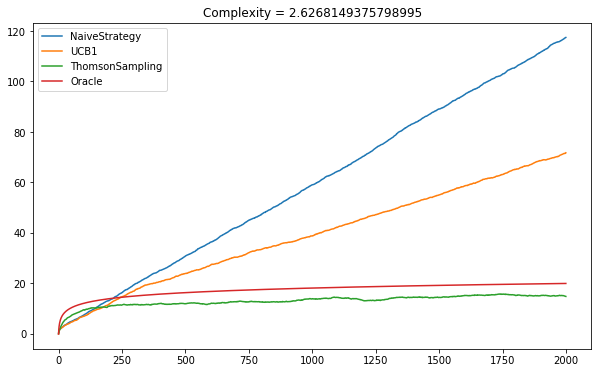

  0%|          | 0/100 [00:00<?, ?it/s]

>> Simulating NaiveStrategy...


  0%|          | 0/100 [00:00<?, ?it/s]

>> Simulating UCB1...


  0%|          | 0/100 [00:00<?, ?it/s]

>> Simulating ThomsonSampling...


 26%|██▌       | 26/100 [00:21<01:01,  1.20it/s]

KeyboardInterrupt: 

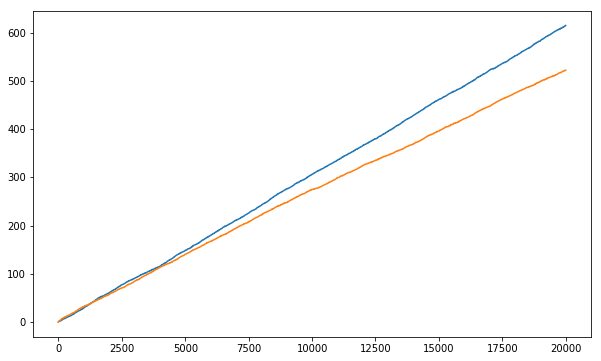

In [28]:
algorithms = {
        'NaiveStrategy': NaiveStrategy,
        'UCB1': UCB1,
        'ThomsonSampling': ThomsonSampling
}


for mab, T in zip([mab_easy, mab_hard], [2000, 20000]):
    
    p_star = np.max(mab.means)
    complexity = mab.compute_complexity()

    plt.figure(figsize=(10, 6))

    for name, algorithm in algorithms.items():
        print('>> Simulating {}...'.format(name))

        cumulative_regret = np.zeros(T)

        for simul in tqdm(range(nb_simuls)):
            mab.reset()
            algorithm(T, mab)
            cumulative_regret += np.cumsum(mab.hist_rewards)

        expected_cumulative_regret = p_star*np.arange(1, T+1) - cumulative_regret / nb_simuls

        plt.plot(expected_cumulative_regret, label=name)

    plt.plot(complexity*np.log(np.arange(1, T + 1)), label='Oracle')    

    plt.legend()
    plt.title('Complexity = {}'.format(complexity))
    plt.show()

# Q2) Non-parametric bandits - Experiments

In [29]:
# Easy problem
     
list_arms_non_param = [arms.ArmBernoulli(0.8),
                  arms.ArmBeta(2,3),
                  arms.ArmExp(1.5),
                  arms.ArmFinite(np.array([0.2, 0.4, 0.6, 0.8, 1]),
                                 np.array([0.1, 0.3, 0.25, 0.25, 0.1]))
                 ]

mab = MAB(list_arms_non_param)

T=5000

In [30]:
algorithms = {
        'NaiveStrategy': NaiveStrategy,
        'UCB1': UCB1,
        'ThomsonSampling': ThomsonSampling
}
    
p_star = np.max(mab.means)

plt.figure(figsize=(10, 6))

for name, algorithm in algorithms.items():
    print('>> Simulating {}...'.format(name))

    cumulative_regret = np.zeros(T)

    for simul in tqdm(range(nb_simuls)):
        mab.reset()
        algorithm(T, mab)
        cumulative_regret += np.cumsum(mab.hist_rewards)

    expected_cumulative_regret = p_star*np.arange(1, T+1) - cumulative_regret / nb_simuls

    plt.plot(expected_cumulative_regret, label=name)

plt.legend()
plt.title('100 simulations')
plt.show()


  1%|          | 1/100 [00:00<00:14,  6.71it/s]

>> Simulating NaiveStrategy...



 34%|███▍      | 34/100 [00:06<00:12,  5.46it/s]

KeyboardInterrupt: 

# Q3) 

In [31]:
from linearmab_models import ColdStartMovieLensModel

- Import data and set parameters

In [32]:
cd TP2_python/

[Errno 2] No such file or directory: 'TP2_python/'
/Users/gregoire/Documents/MVA/Reinforcement Learning/TP2/TP2_python


In [43]:
def epsilon_greedy(upper_bounds, eps, n_a):
    
    if np.random.rand() <= eps:
        return random(n_a)
    else:
        return np.argmax(upper_bounds)

In [162]:
random_state = 0#np.random.randint(0, 24532523)

'''model = ToyLinearModel(
    n_features=8,
    n_actions=20,
    random_state=random_state,
    noise=0.1)
'''

model = ColdStartMovieLensModel(
    random_state=random_state,
    noise=0.1
)

n_a = model.n_actions
d = model.n_features
V = model.features
lmbd = 0.1
epsilon = 0.1

T = 5000
nb_simu = 10 # you may want to change this!

alpha = 1000









Simulating LinUCB:   0%|          | 0/10 [00:00<?, ?it/s]

>> Simulating algorithm LinUCB










Simulating LinUCB:  10%|█         | 1/10 [00:02<00:19,  2.16s/it]







Simulating LinUCB:  20%|██        | 2/10 [00:04<00:19,  2.47s/it]







Simulating LinUCB:  30%|███       | 3/10 [00:12<00:29,  4.23s/it]







Simulating LinUCB:  40%|████      | 4/10 [00:19<00:28,  4.76s/it]







Simulating LinUCB:  50%|█████     | 5/10 [00:24<00:24,  4.82s/it]







Simulating LinUCB:  60%|██████    | 6/10 [00:26<00:17,  4.34s/it]







Simulating LinUCB:  70%|███████   | 7/10 [00:32<00:13,  4.63s/it]







Simulating LinUCB:  80%|████████  | 8/10 [00:39<00:09,  4.95s/it]







Simulating LinUCB:  90%|█████████ | 9/10 [00:46<00:05,  5.13s/it]







Simulating LinUCB: 100%|██████████| 10/10 [00:52<00:00,  5.30s/it]















Simulating eps-greedy:   0%|          | 0/10 [00:00<?, ?it/s]

>> Simulating algorithm eps-greedy










Simulating eps-greedy:  10%|█         | 1/10 [00:07<01:10,  7.81s/it]







Simulating eps-greedy:  20%|██        | 2/10 [00:16<01:04,  8.03s/it]







Simulating eps-greedy:  30%|███       | 3/10 [00:23<00:54,  7.79s/it]







Simulating eps-greedy:  40%|████      | 4/10 [00:32<00:48,  8.16s/it]







Simulating eps-greedy:  50%|█████     | 5/10 [00:42<00:42,  8.42s/it]







Simulating eps-greedy:  60%|██████    | 6/10 [00:55<00:37,  9.30s/it]







Simulating eps-greedy:  70%|███████   | 7/10 [01:05<00:27,  9.31s/it]







Simulating eps-greedy:  80%|████████  | 8/10 [01:15<00:18,  9.46s/it]







Simulating eps-greedy:  90%|█████████ | 9/10 [01:22<00:09,  9.22s/it]







Simulating eps-greedy: 100%|██████████| 10/10 [01:35<00:00,  9.51s/it]















Simulating random:   0%|          | 0/10 [00:00<?, ?it/s]

>> Simulating algorithm random










Simulating random:  10%|█         | 1/10 [00:14<02:13, 14.82s/it]







Simulating random:  20%|██        | 2/10 [00:23<01:35, 11.92s/it]







Simulating random:  30%|███       | 3/10 [00:30<01:11, 10.23s/it]







Simulating random:  40%|████      | 4/10 [00:37<00:56,  9.39s/it]







Simulating random:  50%|█████     | 5/10 [00:46<00:46,  9.24s/it]







Simulating random:  60%|██████    | 6/10 [00:54<00:36,  9.12s/it]







Simulating random:  70%|███████   | 7/10 [01:01<00:26,  8.86s/it]







Simulating random:  80%|████████  | 8/10 [01:10<00:17,  8.75s/it]







Simulating random:  90%|█████████ | 9/10 [01:18<00:08,  8.70s/it]







Simulating random: 100%|██████████| 10/10 [01:30<00:00,  9.04s/it]









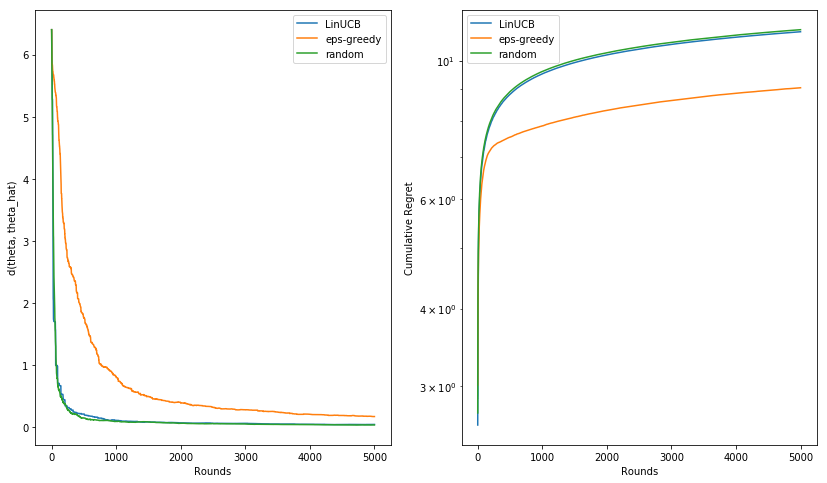

In [163]:
algorithms = [{'name': 'LinUCB', 'eps': 0},
              {'name': 'eps-greedy', 'eps': epsilon},
              {'name': 'random', 'eps': 1}]

p_star = model.best_arm_reward()

plt.figure(figsize=(14, 8))


for algo in algorithms:
    
    eps = algo['eps']
    name = algo['name']
    
    print('>> Simulating algorithm {}'.format(name))
    
    regret = np.zeros((nb_simu, T))
    norm_dist = np.zeros((nb_simu, T))

    for k in tqdm(range(nb_simu), desc="Simulating {}".format(name)):

        # Initialization (the first theta_hat is null)
        A = lmbd * np.identity(d)
        b = np.zeros(d)

        for t in range(T):
             
            # Estimation of theta_hat
            inv = np.linalg.inv(A)
            theta_hat = inv.dot(b)

            # Optimal arm
            beta = alpha * np.sqrt(d*np.log(t+1) + 1) * np.sqrt(np.diagonal(V.dot(inv.dot(V.T))))
            
            if name == 'LinUCB':
                upper_bounds = V.dot(theta_hat) + beta
            else:
                upper_bounds = V.dot(theta_hat)
            
            a_t = epsilon_greedy(upper_bounds, eps, n_a)

            # Get the observed reward 
            r_t = model.reward(a_t)

            # Update A and b
            features_a_t = V[a_t].reshape(-1, 1)
            A += features_a_t.dot(features_a_t.T)
            b += r_t * features_a_t.flatten()
            
            # store regret
            regret[k, t] = model.best_arm_reward() - r_t
            norm_dist[k, t] = np.linalg.norm(theta_hat - model.real_theta, 2)
            

    # compute average (over sim) of the algorithm performance and plot it
    mean_norms = np.mean(norm_dist, axis=0)
    mean_regret = np.mean(regret, axis=0)

    plt.subplot(121)
    plt.plot(mean_norms, label=name)
    plt.ylabel('d(theta, theta_hat)')
    plt.xlabel('Rounds')
    plt.legend()

    plt.subplot(122)
    plt.plot(np.log(mean_regret.cumsum()), label=name)
    plt.ylabel('Cumulative Regret')
    plt.yscale('log')
    plt.xlabel('Rounds')
    plt.legend()

plt.show()